### Spark Structured Straming 

In [1]:
from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.sql.functions import col
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
spark = SparkSession.builder \
.master("local") \
.appName("Exercise+2") \
.getOrCreate()

In [3]:
psdf = spark.read.csv("data.csv", header=True, inferSchema=True)

In [4]:
display(psdf.show(4))

+---+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
|_c0|         dateTime|indicator_rain|precipitation|indicator_temp|air_temperature|indicator_wetb|wetb|dewpt|vappr|relative_humidity|   msl|indicator_wdsp|wind_speed|indicator_wddir|wind_from_direction|
+---+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
| 14|01-jan-1990 00:00|             0|          0.3|             0|            9.1|             0| 9.0|  8.9| 11.4|               99|1006.7|             2|         7|              2|                190|
| 15|01-jan-1990 01:00|             0|          0.2|             0|            8.2|             0| 7.4|  6.4|  9.7|               89|1006.7|             2|         5|              2|      

None

In [5]:
psdf.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- indicator_rain: integer (nullable = true)
 |-- precipitation: string (nullable = true)
 |-- indicator_temp: integer (nullable = true)
 |-- air_temperature: string (nullable = true)
 |-- indicator_wetb: integer (nullable = true)
 |-- wetb: string (nullable = true)
 |-- dewpt: string (nullable = true)
 |-- vappr: string (nullable = true)
 |-- relative_humidity: string (nullable = true)
 |-- msl: string (nullable = true)
 |-- indicator_wdsp: integer (nullable = true)
 |-- wind_speed: string (nullable = true)
 |-- indicator_wddir: integer (nullable = true)
 |-- wind_from_direction: integer (nullable = true)



In [8]:
psdf.createOrReplaceTempView('weatherCondition')
staticSchema  = psdf.schema

In [10]:
print(staticSchema)

StructType(List(StructField(_c0,IntegerType,true),StructField(dateTime,StringType,true),StructField(indicator_rain,IntegerType,true),StructField(precipitation,StringType,true),StructField(indicator_temp,IntegerType,true),StructField(air_temperature,StringType,true),StructField(indicator_wetb,IntegerType,true),StructField(wetb,StringType,true),StructField(dewpt,StringType,true),StructField(vappr,StringType,true),StructField(relative_humidity,StringType,true),StructField(msl,StringType,true),StructField(indicator_wdsp,IntegerType,true),StructField(wind_speed,StringType,true),StructField(indicator_wddir,IntegerType,true),StructField(wind_from_direction,IntegerType,true)))

In [17]:
from pyspark.sql import functions as F

psdf.filter((F.col('air_temperature') < 5)).show()

+---+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
|_c0|         dateTime|indicator_rain|precipitation|indicator_temp|air_temperature|indicator_wetb|wetb|dewpt|vappr|relative_humidity|   msl|indicator_wdsp|wind_speed|indicator_wddir|wind_from_direction|
+---+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
|298|12-jan-1990 20:00|             3|          0.0|             0|            4.9|             0| 4.3|  3.4|  7.8|               90|1025.5|             2|         1|              2|                210|
|300|12-jan-1990 22:00|             3|          0.0|             0|            3.9|             0| 3.2|  2.1|  7.1|               88|1025.9|             2|         1|              2|      

In [19]:
q1 = 'select * from weatherCondition where air_temperature < 5'

out = spark.sql(q1)

out.show(4)

+---+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
|_c0|         dateTime|indicator_rain|precipitation|indicator_temp|air_temperature|indicator_wetb|wetb|dewpt|vappr|relative_humidity|   msl|indicator_wdsp|wind_speed|indicator_wddir|wind_from_direction|
+---+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
|298|12-jan-1990 20:00|             3|          0.0|             0|            4.9|             0| 4.3|  3.4|  7.8|               90|1025.5|             2|         1|              2|                210|
|300|12-jan-1990 22:00|             3|          0.0|             0|            3.9|             0| 3.2|  2.1|  7.1|               88|1025.9|             2|         1|              2|      

In [46]:
#Streaming

streamingDF = spark.readStream\
.schema(staticSchema)\
.option('maxFilesPerTrigger',1)\
.format('csv')\
.option('header', 'true')\
.load('data.csv')

In [47]:
filteredDF = streamingDF.filter((F.col('air_temperature')<5))

In [48]:
streamingDF.isStreaming

True

In [51]:
df = filteredDF.writeStream.format("memory") \
.queryName("weatherQuery") \
.outputMode("update") \
.start()


In [52]:
spark.sql("""
SELECT *
FROM weatherQuery
""")\
.show(5)

+---+--------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+---+--------------+----------+---------------+-------------------+
|_c0|dateTime|indicator_rain|precipitation|indicator_temp|air_temperature|indicator_wetb|wetb|dewpt|vappr|relative_humidity|msl|indicator_wdsp|wind_speed|indicator_wddir|wind_from_direction|
+---+--------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+---+--------------+----------+---------------+-------------------+
+---+--------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+---+--------------+----------+---------------+-------------------+



In [45]:
streamingDF = spark.readStream \
    .schema(staticSchema) \
    .option('maxFilesPerTrigger', 1) \
    .format('csv') \
    .option('header', 'true') \
    .load('data.csv')

# Apply filter on streaming DataFrame
filteredDF = streamingDF.filter((F.col('air_temperature') < 5))

# Write the filtered DataFrame to memory
df = filteredDF.writeStream.format("memory") \
    .queryName("weatherQuery") \
    .outputMode("append") \
    .start()
df.awaitTermination()
# No need to await termination when using .start()

# Query the streaming result
# spark.sql("""
# SELECT *
# FROM weatherQuery
# """) \
#     .show(5)

StreamingQueryException: Option 'basePath' must be a directory
=== Streaming Query ===
Identifier: weatherQuery [id = 166447b6-0674-4c58-8d21-4ece07a188e7, runId = f4c0fd51-1502-4d7e-b048-ed75e54fa312]
Current Committed Offsets: {}
Current Available Offsets: {FileStreamSource[file:/home/jovyan/data.csv]: {"logOffset":0}}

Current State: ACTIVE
Thread State: RUNNABLE

Logical Plan:
WriteToMicroBatchDataSource org.apache.spark.sql.execution.streaming.sources.MemoryStreamingWrite@14739995
+- Filter (cast(air_temperature#1114 as int) < 5)
   +- StreamingExecutionRelation FileStreamSource[file:/home/jovyan/data.csv], [_c0#1109, dateTime#1110, indicator_rain#1111, precipitation#1112, indicator_temp#1113, air_temperature#1114, indicator_wetb#1115, wetb#1116, dewpt#1117, vappr#1118, relative_humidity#1119, msl#1120, indicator_wdsp#1121, wind_speed#1122, indicator_wddir#1123, wind_from_direction#1124]


## Access file from URL

In [88]:
from pyspark import SparkFiles

spark.sparkContext.addFile('https://cli.fusio.net/cli/climate_data/webdata/hly1075.csv')

df_url = spark.read.csv(SparkFiles.get("hly1075.csv"), header=True)

In [89]:
df_url.show(12)

+--------------------------+
|Station Name: ROCHES POINT|
+--------------------------+
|      Station Height: 4...|
|         Latitude:51.793  |
|      date:  -  Date an...|
|      rain:  -  Precipi...|
|      temp:  -  Air Tem...|
|      wetb:  -  Wet Bul...|
|      dewpt: -  Dew Poi...|
|      vappr: -  Vapour ...|
|      rhum:  -  Relativ...|
|      msl:   -  Mean Se...|
|      wdsp:  -  Mean Wi...|
|      wddir: -  Predomi...|
+--------------------------+
only showing top 12 rows



In [30]:
#Write to csv
df_url.write.csv('hly1075.csv', header=True)

## Select column, count, distinct, round

In [90]:
psdf.select(col('air_temperature')).show(5)

+---------------+
|air_temperature|
+---------------+
|            9.1|
|            8.2|
|            7.9|
|            7.8|
|            8.0|
+---------------+
only showing top 5 rows



In [36]:
psdf.select(f.count('air_temperature')).show()

+----------------------+
|count(air_temperature)|
+----------------------+
|                245088|
+----------------------+



In [38]:
psdf.select("wetb").count()

245088

In [39]:
psdf.select("wetb").distinct().count()

264

In [45]:
psdf = psdf.drop("_c0")

In [91]:
psdf.withColumn("air_temperature",f.round(psdf["air_temperature"],
1)).show(5)

+---+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
|_c0|         dateTime|indicator_rain|precipitation|indicator_temp|air_temperature|indicator_wetb|wetb|dewpt|vappr|relative_humidity|   msl|indicator_wdsp|wind_speed|indicator_wddir|wind_from_direction|
+---+-----------------+--------------+-------------+--------------+---------------+--------------+----+-----+-----+-----------------+------+--------------+----------+---------------+-------------------+
| 14|01-jan-1990 00:00|             0|          0.3|             0|            9.1|             0| 9.0|  8.9| 11.4|               99|1006.7|             2|         7|              2|                190|
| 15|01-jan-1990 01:00|             0|          0.2|             0|            8.2|             0| 7.4|  6.4|  9.7|               89|1006.7|             2|         5|              2|      

## Visualization

In [5]:
from pyspark.sql.types import *

# Change column type
psdf = psdf .withColumn("precipitation", psdf["precipitation"].cast(FloatType()))\
            .withColumn("air_temperature", psdf["air_temperature"].cast(FloatType()))\
            .withColumn("wetb", psdf["wetb"].cast(FloatType()))\
            .withColumn("dewpt", psdf["dewpt"].cast(FloatType()))\
            .withColumn("vappr", psdf["vappr"].cast(FloatType()))\
            .withColumn("relative_humidity", psdf["relative_humidity"].cast(IntegerType()))\
            .withColumn("wind_speed", psdf["wind_speed"].cast(IntegerType()))\
            .withColumn("msl", psdf["msl"].cast(FloatType()))

psdf.printSchema()


root
 |-- _c0: integer (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- indicator_rain: integer (nullable = true)
 |-- precipitation: float (nullable = true)
 |-- indicator_temp: integer (nullable = true)
 |-- air_temperature: float (nullable = true)
 |-- indicator_wetb: integer (nullable = true)
 |-- wetb: float (nullable = true)
 |-- dewpt: float (nullable = true)
 |-- vappr: float (nullable = true)
 |-- relative_humidity: integer (nullable = true)
 |-- msl: float (nullable = true)
 |-- indicator_wdsp: integer (nullable = true)
 |-- wind_speed: integer (nullable = true)
 |-- indicator_wddir: integer (nullable = true)
 |-- wind_from_direction: integer (nullable = true)



In [7]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('seaborn-white')
plt.style.use('seaborn-white')

df = psdf.toPandas()

In [8]:
#Formatting date_time for pandas
df['date_time'] = pd.to_datetime(df["dateTime"], format='%d-%b-%Y %H:%M')

In [9]:
df.head()

,_c0,dateTime,indicator_rain,precipitation,indicator_temp,air_temperature,indicator_wetb,wetb,dewpt,vappr,relative_humidity,msl,indicator_wdsp,wind_speed,indicator_wddir,wind_from_direction,date_time
0,14,01-jan-1990 00:00,0,0.3,0,9.1,0,9.0,8.9,11.4,99.0,1006.700012,2,7.0,2,190.0,1990-01-01 00:00:00
1,15,01-jan-1990 01:00,0,0.2,0,8.2,0,7.4,6.4,9.7,89.0,1006.700012,2,5.0,2,220.0,1990-01-01 01:00:00
2,16,01-jan-1990 02:00,0,0.0,0,7.9,0,7.4,6.8,9.9,93.0,1006.900024,2,1.0,2,190.0,1990-01-01 02:00:00
3,17,01-jan-1990 03:00,3,0.0,0,7.8,0,7.5,7.1,10.1,96.0,1007.099976,2,1.0,2,190.0,1990-01-01 03:00:00
4,18,01-jan-1990 04:00,3,0.0,0,8.0,0,7.3,6.5,9.7,90.0,1007.299988,2,2.0,2,220.0,1990-01-01 04:00:00


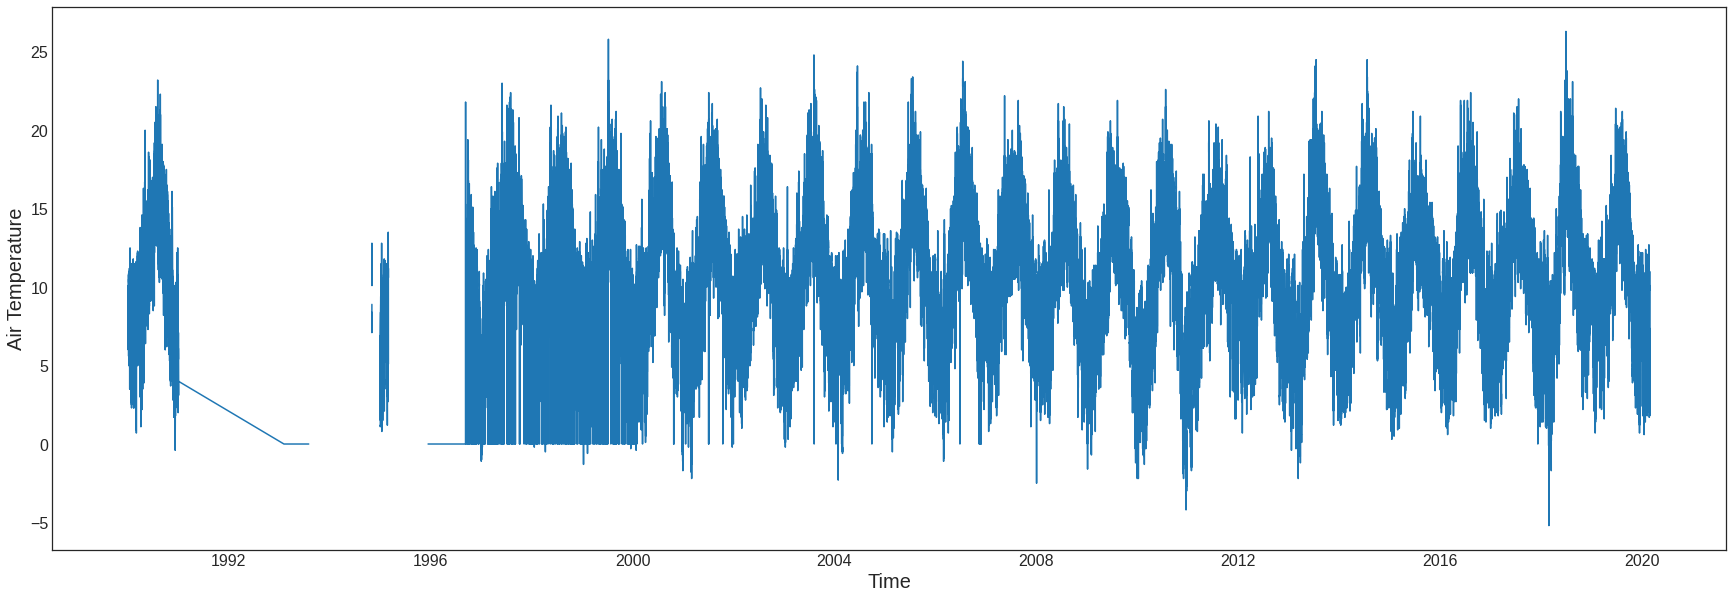

In [10]:
plt.figure(figsize=(30, 10)) 
plt.plot(df['date_time'], df['air_temperature'])
plt.xlabel('Time', fontsize=20)  # Increase x-axis label font size
plt.ylabel('Air Temperature', fontsize=20)  # Increase y-axis label font size
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

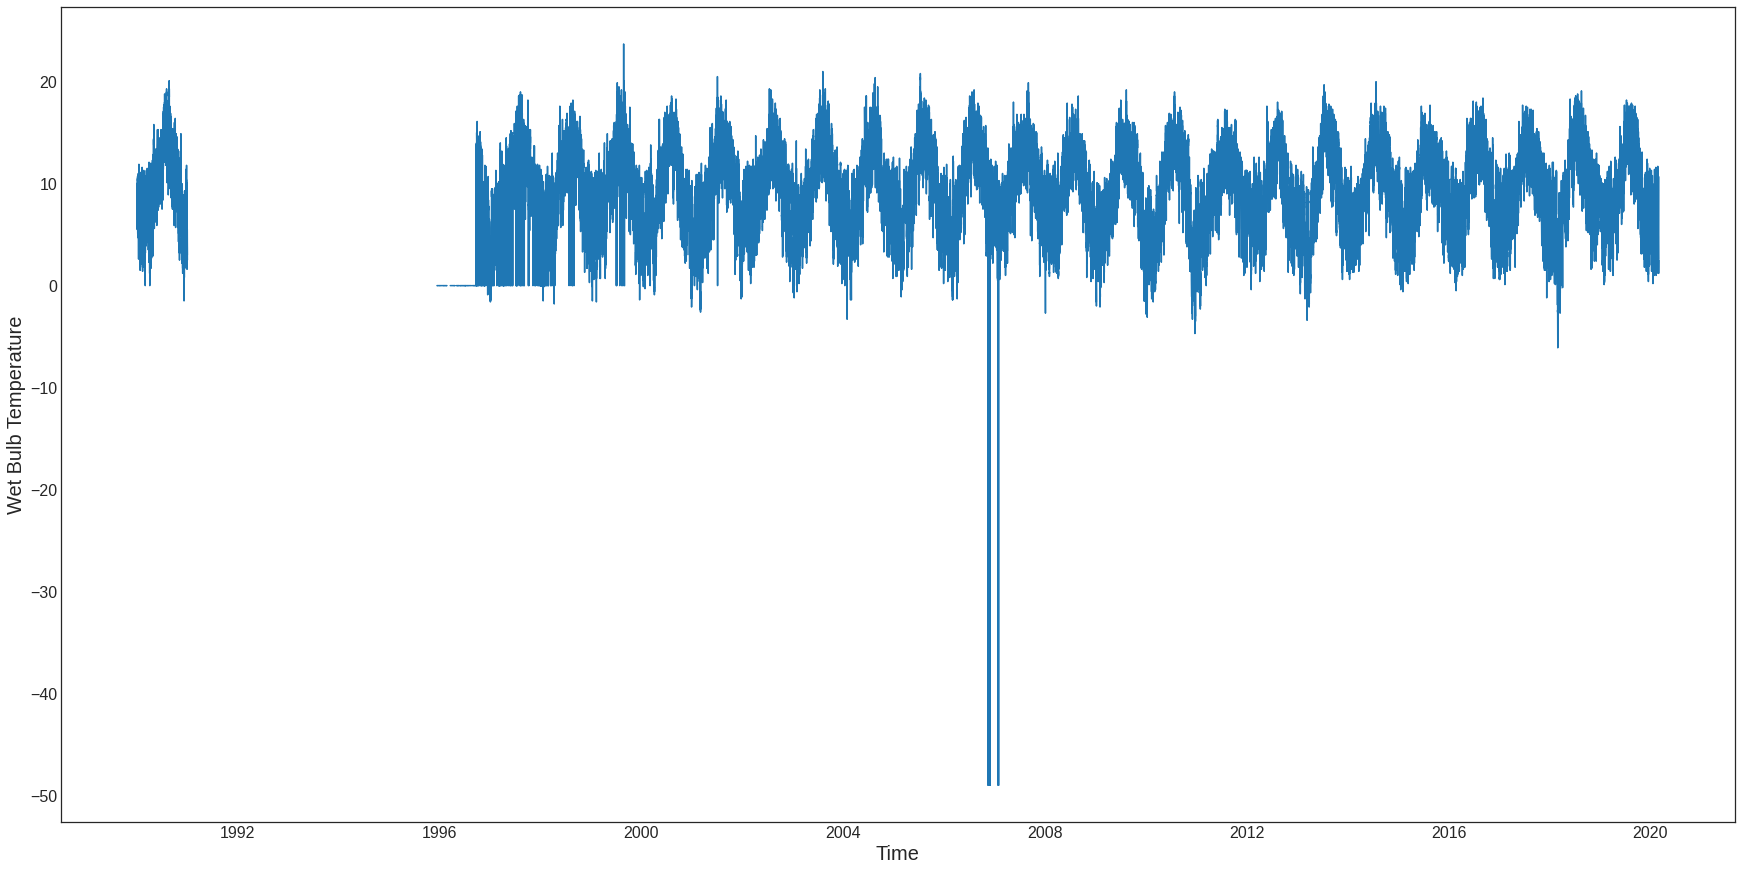

In [12]:
plt.figure(figsize=(30, 15)) 
plt.plot(df['date_time'], df['wetb'])
plt.xlabel('Time', fontsize=20)  
plt.ylabel('Wet Bulb Temperature', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.show()

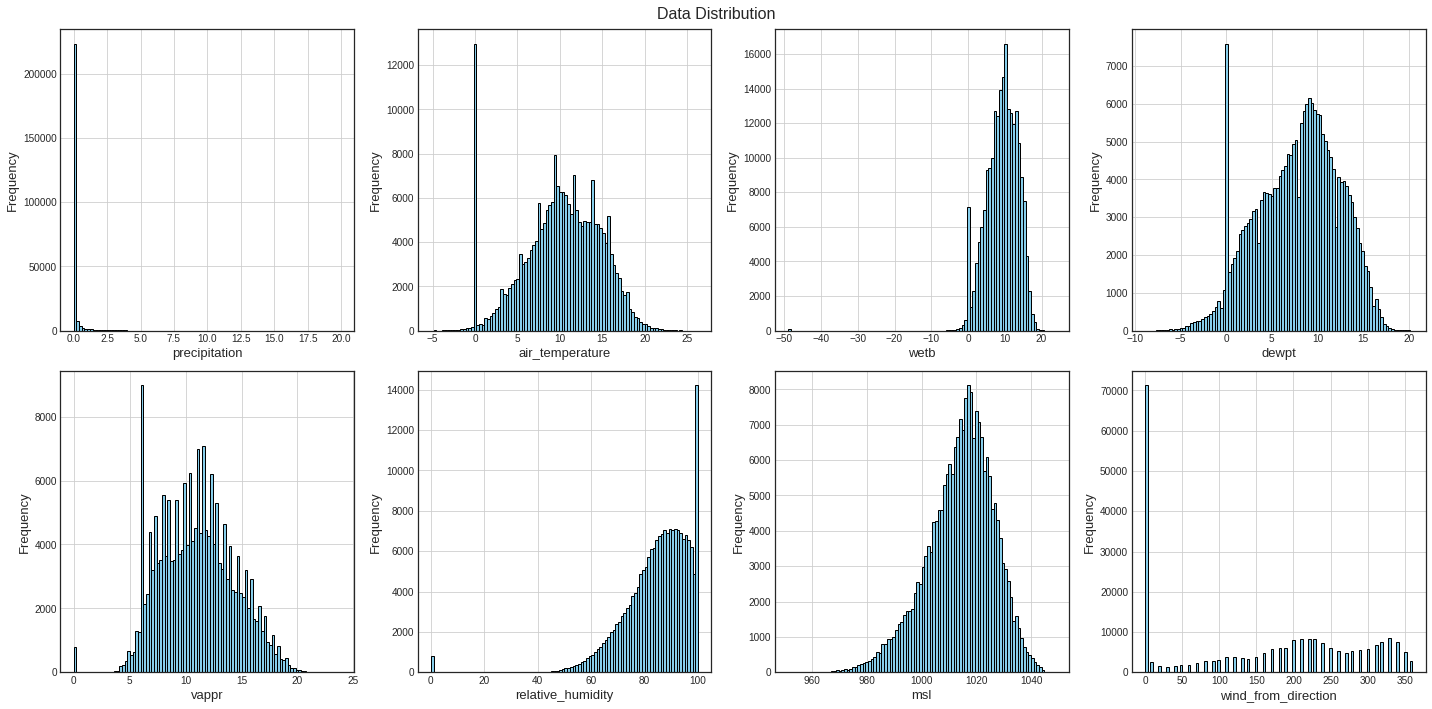

In [19]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))

# Plotting histograms for each column
for i, column in enumerate(['precipitation', 'air_temperature', 'wetb', 'dewpt', 'vappr',
       'relative_humidity', 'msl', 'wind_from_direction']):
    ax = axs[i // 4, i % 4]  # Determine subplot index
    ax.hist(df[column], bins=100, color='skyblue', edgecolor='black')
    #ax.set_title(column,fontsize=13)
    ax.set_xlabel(column,fontsize=13)
    ax.set_ylabel('Frequency', fontsize=13)
    ax.grid(True)

# Adjust layout
plt.suptitle("Data Distribution", fontsize=16)
plt.tight_layout()
plt.show()